# FFT Analysis for Art Artifact Detection and Restoration

This notebook demonstrates how Fast Fourier Transform (FFT) can be used in art analysis for:
- Identifying forgeries through frequency domain analysis
- Detecting restoration artifacts
- Comparing original vs. restored artworks

We'll use OpenCV, NumPy, and Matplotlib to perform the analysis on real and damaged art images.

## 1. Import Required Libraries

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path
from sklearn.decomposition import PCA

# Configure matplotlib for better visualizations
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)
plt.style.use('ggplot')

## 2. Define Helper Functions for FFT Analysis

In [2]:
def load_image(path, grayscale=True, size=None):
    """Load an image with optional resizing and grayscale conversion."""
    if grayscale:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    else:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    
    if img is None:
        raise FileNotFoundError(f"Could not load image at {path}")
    
    if size is not None:
        img = cv2.resize(img, size)
    
    return img

def compute_fft(img):
    """Compute the 2D FFT of an image and return the shifted spectrum."""
    # Apply FFT
    f = np.fft.fft2(img)
    # Shift zero frequency to center
    fshift = np.fft.fftshift(f)
    return fshift

def compute_magnitude_spectrum(fshift):
    """Compute magnitude spectrum from shifted FFT."""
    # Calculate magnitude spectrum
    # Adding 1 to avoid log(0) and scaling for better visualization
    magnitude = 20 * np.log(np.abs(fshift) + 1)
    return magnitude

def apply_filter(fshift, filter_mask):
    """Apply a filter mask to the shifted FFT and compute inverse FFT."""
    filtered_fshift = fshift * filter_mask
    # Inverse shift
    f_ishift = np.fft.ifftshift(filtered_fshift)
    # Inverse FFT
    img_back = np.fft.ifft2(f_ishift)
    # Get the real part for the image
    img_back = np.abs(img_back)
    return img_back

def create_lowpass_filter(shape, cutoff):
    """Create a circular low-pass filter mask."""
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    
    mask = np.zeros((rows, cols), np.uint8)
    cv2.circle(mask, (ccol, crow), cutoff, 1, -1)
    
    return mask

def create_highpass_filter(shape, cutoff):
    """Create a circular high-pass filter mask."""
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    
    mask = np.ones((rows, cols), np.uint8)
    cv2.circle(mask, (ccol, crow), cutoff, 0, -1)
    
    return mask

def create_bandpass_filter(shape, inner_cutoff, outer_cutoff):
    """Create a band-pass filter mask."""
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    
    mask = np.zeros((rows, cols), np.uint8)
    cv2.circle(mask, (ccol, crow), outer_cutoff, 1, -1)
    cv2.circle(mask, (ccol, crow), inner_cutoff, 0, -1)
    
    return mask

def visualize_fft_analysis(img, title="FFT Analysis"):
    """Complete FFT analysis with original, spectrum, and filtered images."""
    # Compute FFT and magnitude spectrum
    fshift = compute_fft(img)
    magnitude = compute_magnitude_spectrum(fshift)
    
    # Create filters
    rows, cols = img.shape
    lowpass_mask = create_lowpass_filter((rows, cols), cutoff=30)
    highpass_mask = create_highpass_filter((rows, cols), cutoff=30)
    bandpass_mask = create_bandpass_filter((rows, cols), inner_cutoff=10, outer_cutoff=50)
    
    # Apply filters
    img_lowpass = apply_filter(fshift, lowpass_mask)
    img_highpass = apply_filter(fshift, highpass_mask)
    img_bandpass = apply_filter(fshift, bandpass_mask)
    
    # Visualize results
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(title, fontsize=16)
    
    # Original image and magnitude spectrum
    axs[0, 0].imshow(img, cmap='gray')
    axs[0, 0].set_title('Original Image')
    axs[0, 0].axis('off')
    
    axs[0, 1].imshow(magnitude, cmap='gray')
    axs[0, 1].set_title('Magnitude Spectrum')
    axs[0, 1].axis('off')
    
    # Filters
    axs[0, 2].imshow(lowpass_mask, cmap='gray')
    axs[0, 2].set_title('Low-pass Filter')
    axs[0, 2].axis('off')
    
    # Filtered images
    axs[1, 0].imshow(img_lowpass, cmap='gray')
    axs[1, 0].set_title('Low-pass Filtered')
    axs[1, 0].axis('off')
    
    axs[1, 1].imshow(img_highpass, cmap='gray')
    axs[1, 1].set_title('High-pass Filtered')
    axs[1, 1].axis('off')
    
    axs[1, 2].imshow(img_bandpass, cmap='gray')
    axs[1, 2].set_title('Band-pass Filtered')
    axs[1, 2].axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    return magnitude, img_lowpass, img_highpass, img_bandpass

## 3. Load and Analyze Sample Images from the Dataset

Let's load a pair of damaged and undamaged artwork samples and perform FFT analysis on them.

Found 114 damaged images and 114 undamaged images
Selected sample file: 1.png


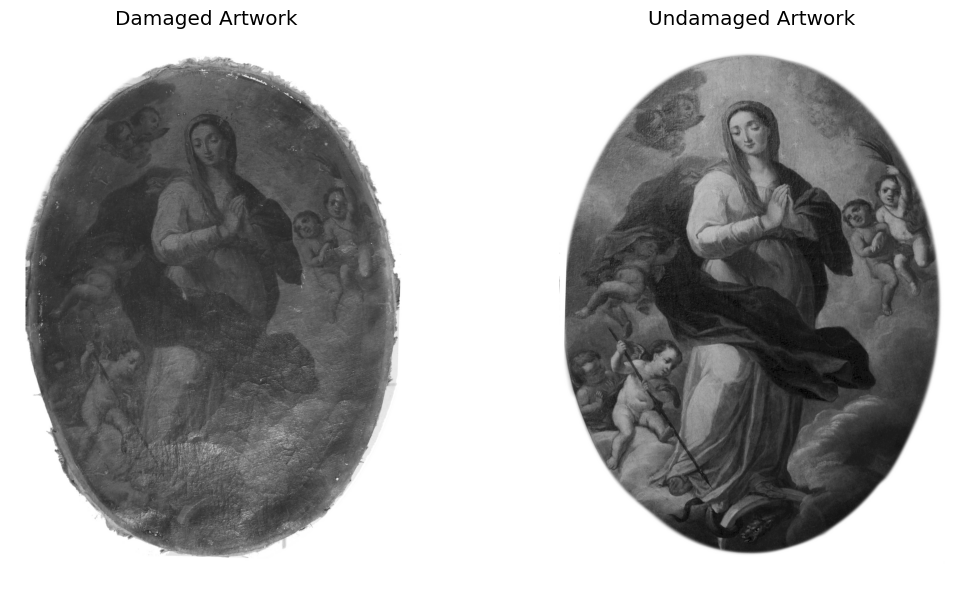

In [6]:
# Set paths to our dataset
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, project_root)
#DATA_PATH = "../../data/raw/AI_for_Art_Restoration_2/paired_dataset_art"
data_path = os.path.join(project_root, "data/raw/AI_for_Art_Restoration_2/paired_dataset_art")
damaged_dir = os.path.join(data_path, "damaged")
undamaged_dir = os.path.join(data_path, "undamaged")

# List image files
damaged_files = os.listdir(damaged_dir)
undamaged_files = os.listdir(undamaged_dir)

print(f"Found {len(damaged_files)} damaged images and {len(undamaged_files)} undamaged images")

# Select a sample image file that exists in both directories
common_files = [f for f in damaged_files if f in undamaged_files]
if common_files:
    sample_file = common_files[0]
    print(f"Selected sample file: {sample_file}")
    
    # Load both damaged and undamaged versions
    damaged_img = load_image(os.path.join(damaged_dir, sample_file), grayscale=True)
    undamaged_img = load_image(os.path.join(undamaged_dir, sample_file), grayscale=True)
    
    # Display the images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(damaged_img, cmap='gray')
    plt.title('Damaged Artwork')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(undamaged_img, cmap='gray')
    plt.title('Undamaged Artwork')
    plt.axis('off')
    
    plt.tight_layout()
else:
    print("No common files found between damaged and undamaged directories.")
    # In case no common files, just load one from each
    if damaged_files:
        damaged_img = load_image(os.path.join(damaged_dir, damaged_files[0]), grayscale=True)
    else:
        damaged_img = None
        
    if undamaged_files:
        undamaged_img = load_image(os.path.join(undamaged_dir, undamaged_files[0]), grayscale=True)
    else:
        undamaged_img = None

## 4. FFT Analysis of Damaged vs. Undamaged Artwork

Now let's perform FFT analysis on both damaged and undamaged artwork to compare their frequency domain characteristics.

FFT Analysis of Damaged Artwork


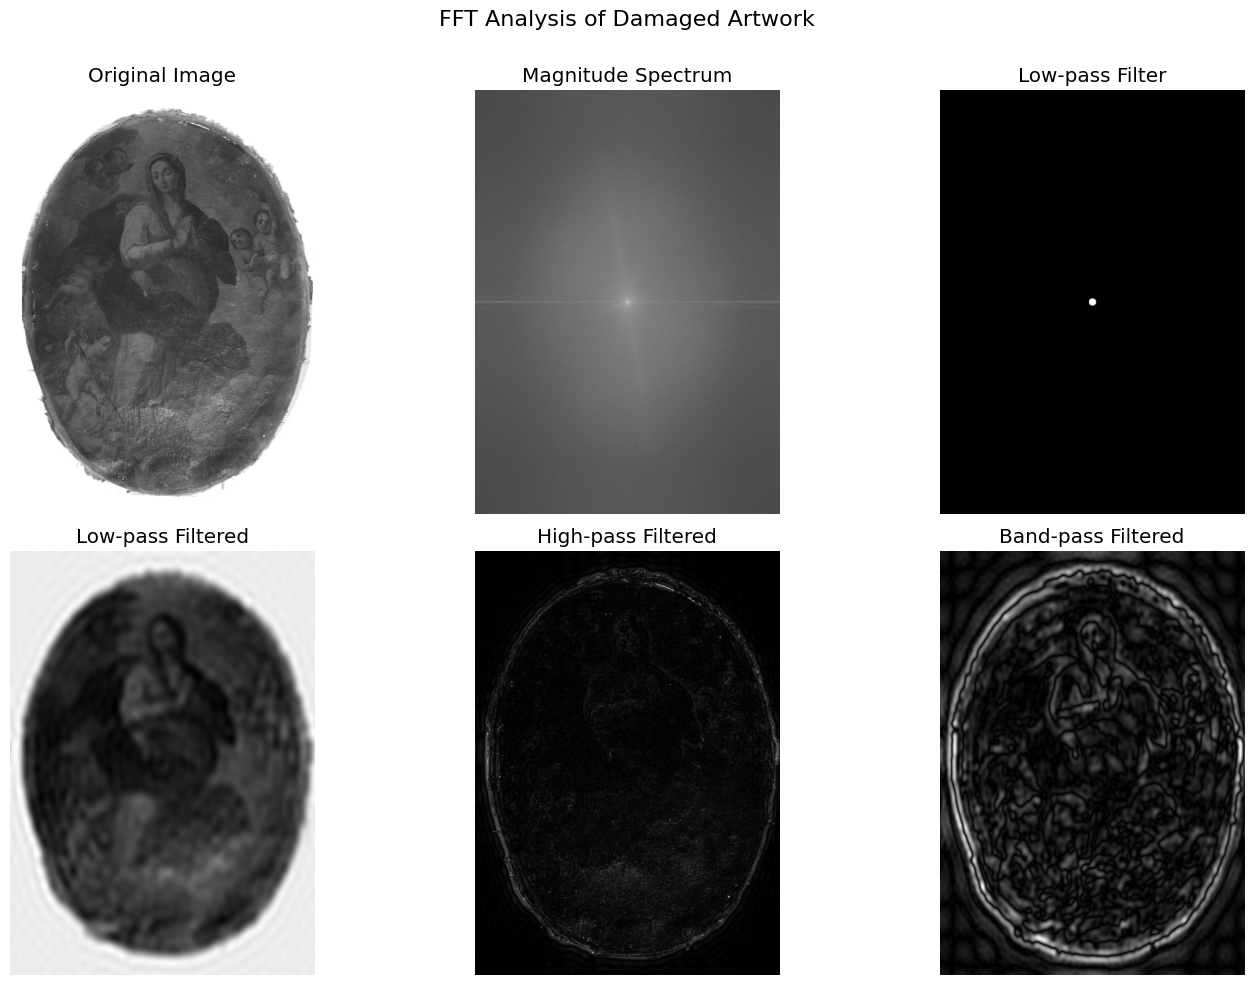

In [8]:
if damaged_img is not None:
    print("FFT Analysis of Damaged Artwork")
    damaged_magnitude, damaged_lp, damaged_hp, damaged_bp = visualize_fft_analysis(damaged_img, "FFT Analysis of Damaged Artwork")

FFT Analysis of Undamaged Artwork


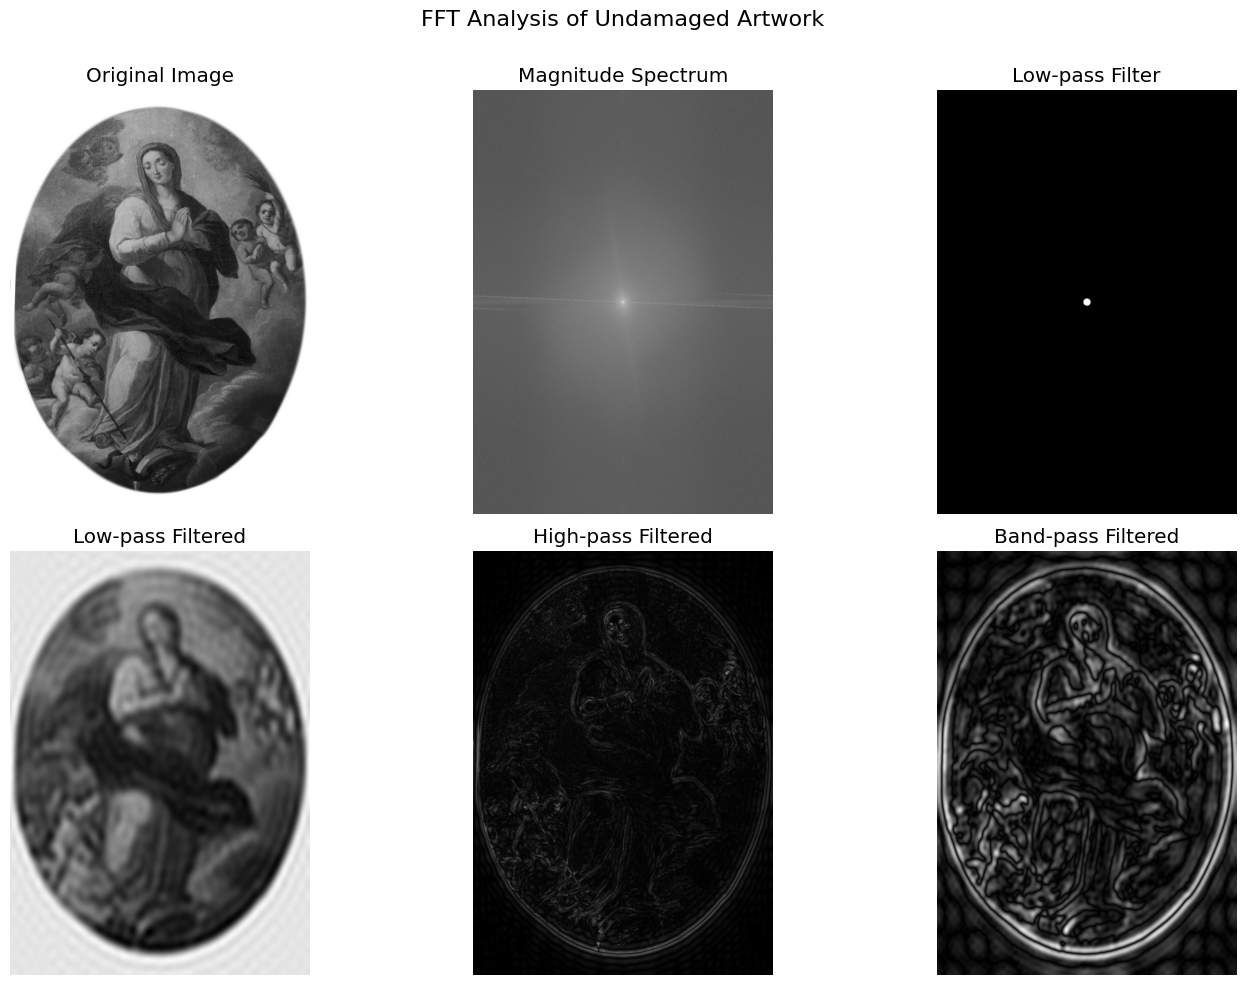

In [9]:
if undamaged_img is not None:
    print("FFT Analysis of Undamaged Artwork")
    undamaged_magnitude, undamaged_lp, undamaged_hp, undamaged_bp = visualize_fft_analysis(undamaged_img, "FFT Analysis of Undamaged Artwork")

## 5. Comparing Frequency Domain Features

Let's compare the frequency domain features between damaged and undamaged artworks.

Mean difference: 13.95
Standard deviation of difference: 10.87
Maximum difference: 134.21


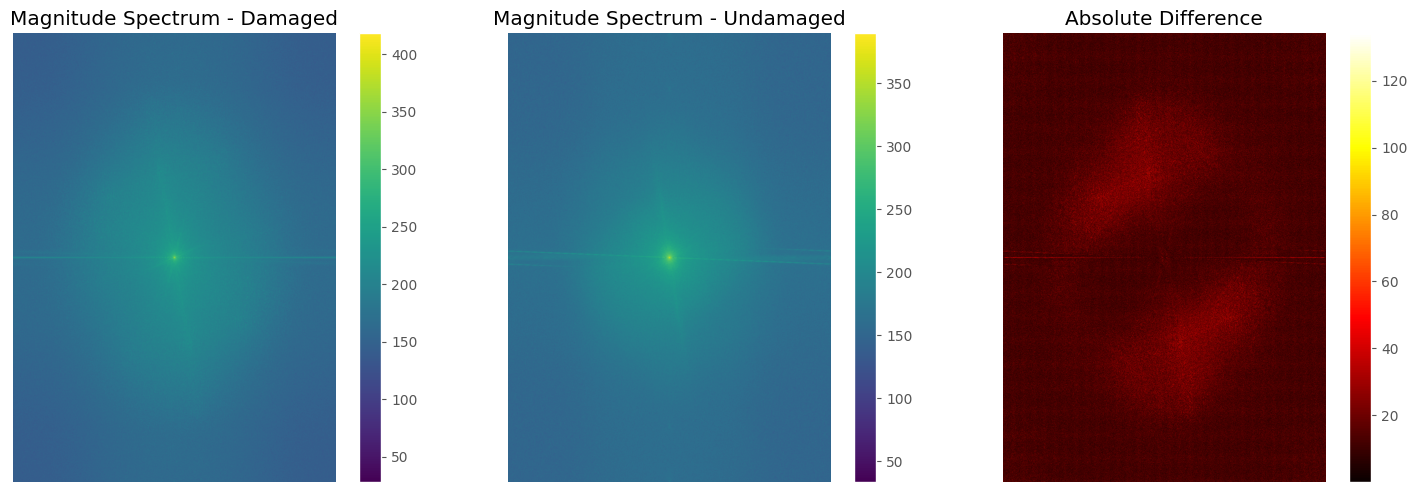

In [10]:
def compare_magnitude_spectra(magnitude1, magnitude2, title1='Image 1', title2='Image 2'):
    """Compare magnitude spectra of two images and compute difference."""
    # Ensure both images are the same size
    if magnitude1.shape != magnitude2.shape:
        # Resize the second image to match the first
        magnitude2 = cv2.resize(magnitude2, (magnitude1.shape[1], magnitude1.shape[0]))
        
    # Calculate difference
    diff = np.abs(magnitude1 - magnitude2)
    
    # Visualize
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(magnitude1, cmap='viridis')
    plt.colorbar()
    plt.title(f'Magnitude Spectrum - {title1}')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(magnitude2, cmap='viridis')
    plt.colorbar()
    plt.title(f'Magnitude Spectrum - {title2}')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(diff, cmap='hot')
    plt.colorbar()
    plt.title('Absolute Difference')
    plt.axis('off')
    
    plt.tight_layout()
    
    # Calculate statistics of the difference
    mean_diff = np.mean(diff)
    std_diff = np.std(diff)
    max_diff = np.max(diff)
    
    print(f"Mean difference: {mean_diff:.2f}")
    print(f"Standard deviation of difference: {std_diff:.2f}")
    print(f"Maximum difference: {max_diff:.2f}")
    
    return diff

# Compare the magnitude spectra if both images are available
if damaged_img is not None and undamaged_img is not None:
    diff = compare_magnitude_spectra(
        damaged_magnitude, 
        undamaged_magnitude, 
        title1='Damaged', 
        title2='Undamaged'
    )

## 6. Extracting and Analyzing Feature Statistics

Let's extract some statistical features from the FFT spectrum that could be useful for detecting forgeries or damage.

In [11]:
def extract_fft_statistics(magnitude):
    """Extract statistical features from FFT magnitude spectrum."""
    # Basic statistics
    mean = np.mean(magnitude)
    std = np.std(magnitude)
    max_val = np.max(magnitude)
    min_val = np.min(magnitude)
    
    # Calculate skewness
    skewness = np.mean(((magnitude - mean) / std) ** 3) if std > 0 else 0
    
    # Calculate kurtosis
    kurtosis = np.mean(((magnitude - mean) / std) ** 4) - 3 if std > 0 else 0
    
    # Calculate energy in different frequency bands
    rows, cols = magnitude.shape
    crow, ccol = rows // 2, cols // 2
    
    # Low frequency energy (center)
    low_freq_region = magnitude[crow-30:crow+30, ccol-30:ccol+30]
    low_freq_energy = np.sum(low_freq_region) / low_freq_region.size if low_freq_region.size > 0 else 0
    
    # High frequency energy (edges)
    high_freq_mask = np.ones_like(magnitude)
    high_freq_mask[crow-30:crow+30, ccol-30:ccol+30] = 0
    high_freq_region = magnitude * high_freq_mask
    high_freq_energy = np.sum(high_freq_region) / np.count_nonzero(high_freq_mask)
    
    # Return as dictionary
    stats = {
        'mean': mean,
        'std_dev': std,
        'max': max_val,
        'min': min_val,
        'skewness': skewness,
        'kurtosis': kurtosis,
        'low_freq_energy': low_freq_energy,
        'high_freq_energy': high_freq_energy,
        'energy_ratio': high_freq_energy / low_freq_energy if low_freq_energy > 0 else float('inf')
    }
    
    return stats

# Extract statistics if both images are available
if damaged_img is not None and undamaged_img is not None:
    damaged_stats = extract_fft_statistics(damaged_magnitude)
    undamaged_stats = extract_fft_statistics(undamaged_magnitude)
    
    # Display statistics
    print("FFT Statistics Comparison:")
    print("-" * 50)
    print(f"{'Feature':<15} {'Damaged':>15} {'Undamaged':>15} {'Difference':>15}")
    print("-" * 50)
    
    for key in damaged_stats.keys():
        damaged_val = damaged_stats[key]
        undamaged_val = undamaged_stats[key]
        diff = damaged_val - undamaged_val
        print(f"{key:<15} {damaged_val:>15.4f} {undamaged_val:>15.4f} {diff:>15.4f}")

FFT Statistics Comparison:
--------------------------------------------------
Feature                 Damaged       Undamaged      Difference
--------------------------------------------------
mean                   172.0788        167.2876          4.7912
std_dev                 24.6517         21.5309          3.1208
max                    418.1309        417.4476          0.6833
min                     28.1144         13.5165         14.5980
skewness                 0.4190          0.7022         -0.2831
kurtosis                 0.4057          2.0534         -1.6477
low_freq_energy        282.2728        293.1029        -10.8301
high_freq_energy        172.0334        167.2354          4.7980
energy_ratio             0.6095          0.5706          0.0389


## 7. Visualizing Differences with Radial Frequency Analysis

Let's analyze the radial frequency content, which can reveal patterns of forgery or damage.

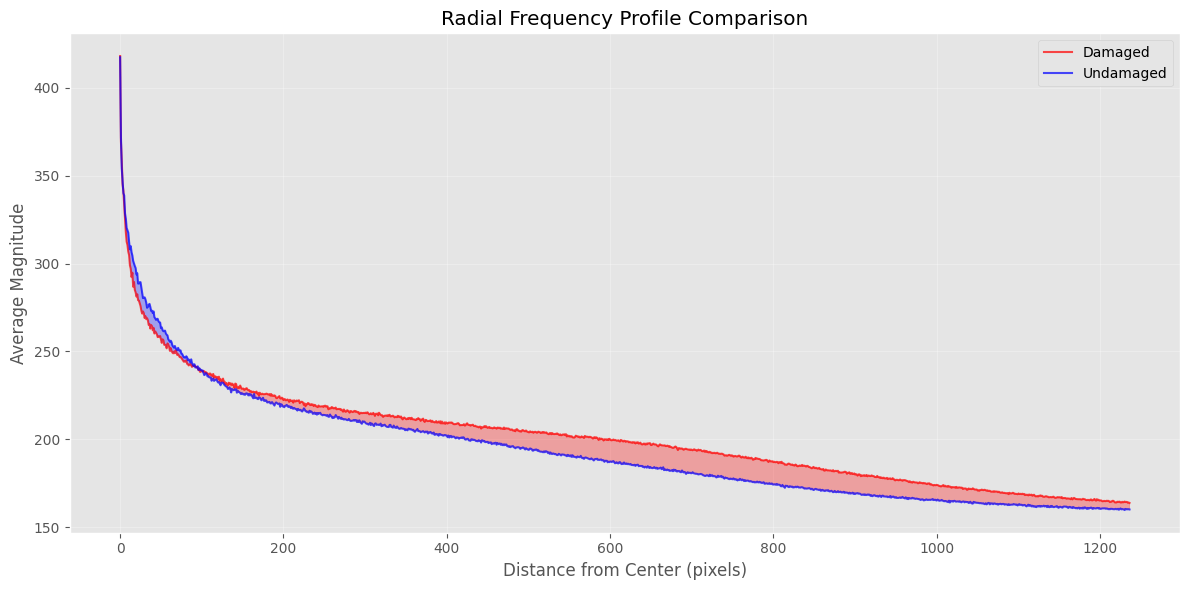

In [12]:
def compute_radial_profile(magnitude):
    """Compute the radial profile of an FFT magnitude spectrum."""
    # Get image dimensions
    rows, cols = magnitude.shape
    center_row, center_col = rows // 2, cols // 2
    
    # Create a coordinate grid
    y, x = np.ogrid[:rows, :cols]
    
    # Calculate distance from center for each pixel
    distance_from_center = np.sqrt((x - center_col)**2 + (y - center_row)**2)
    
    # Round distances to integers
    distance_from_center = distance_from_center.astype(int)
    
    # Maximum radius
    max_radius = min(center_row, center_col)
    
    # Initialize arrays
    radial_profile = np.zeros(max_radius)
    radial_counts = np.zeros(max_radius)
    
    # Compute the radial profile
    for r in range(max_radius):
        mask = (distance_from_center == r)
        if np.any(mask):
            radial_profile[r] = np.mean(magnitude[mask])
            radial_counts[r] = np.sum(mask)
    
    return np.arange(max_radius), radial_profile

# Compute and compare radial profiles
if damaged_img is not None and undamaged_img is not None:
    damaged_radius, damaged_profile = compute_radial_profile(damaged_magnitude)
    undamaged_radius, undamaged_profile = compute_radial_profile(undamaged_magnitude)
    
    # Ensure same length by taking minimum
    min_length = min(len(damaged_profile), len(undamaged_profile))
    damaged_radius = damaged_radius[:min_length]
    damaged_profile = damaged_profile[:min_length]
    undamaged_radius = undamaged_radius[:min_length]
    undamaged_profile = undamaged_profile[:min_length]
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(damaged_radius, damaged_profile, 'r-', label='Damaged', alpha=0.7)
    plt.plot(undamaged_radius, undamaged_profile, 'b-', label='Undamaged', alpha=0.7)
    plt.fill_between(damaged_radius, damaged_profile, undamaged_profile, 
                     where=(damaged_profile > undamaged_profile), 
                     interpolate=True, color='red', alpha=0.3)
    plt.fill_between(damaged_radius, damaged_profile, undamaged_profile, 
                     where=(damaged_profile <= undamaged_profile), 
                     interpolate=True, color='blue', alpha=0.3)
    
    plt.title('Radial Frequency Profile Comparison')
    plt.xlabel('Distance from Center (pixels)')
    plt.ylabel('Average Magnitude')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

## 8. Feature Extraction for Machine Learning

Let's create a function to extract features that could be used in a machine learning model for detection.

In [14]:
def extract_ml_features(image):
    """Extract features for machine learning models from an image."""
    # Compute FFT
    fshift = compute_fft(image)
    magnitude = compute_magnitude_spectrum(fshift)
    
    # Get statistics
    stats = extract_fft_statistics(magnitude)
    
    # Get radial profile
    radii, profile = compute_radial_profile(magnitude)
    
    # Use statistics of radial profile instead of PCA
    # PCA requires n_samples >= n_components, but profile is 1D
    if len(profile) >= 5:
        # Take first few values and some statistics
        profile_features = np.array([
            profile[0] if len(profile) > 0 else 0,  # Center value
            profile[len(profile)//4] if len(profile) > 4 else 0,  # 25% position
            profile[len(profile)//2] if len(profile) > 2 else 0,  # 50% position
            profile[3*len(profile)//4] if len(profile) > 4 else 0,  # 75% position
            profile[-1] if len(profile) > 0 else 0  # Edge value
        ])
    else:
        profile_features = np.zeros(5)  # Default if not enough points
    
    # Create feature vector
    features = np.array([
        stats['mean'],
        stats['std_dev'],
        stats['skewness'],
        stats['kurtosis'],
        stats['low_freq_energy'],
        stats['high_freq_energy'],
        stats['energy_ratio']
    ])
    
    # Add radial profile features
    features = np.concatenate([features, profile_features])
    
    return features

# Extract features from our sample images
if damaged_img is not None and undamaged_img is not None:
    damaged_features = extract_ml_features(damaged_img)
    undamaged_features = extract_ml_features(undamaged_img)
    
    # Display feature vectors
    feature_names = [
        'Mean', 'Std Dev', 'Skewness', 'Kurtosis', 
        'Low Freq Energy', 'High Freq Energy', 'Energy Ratio',
        'Radial Center', 'Radial 25%', 'Radial 50%', 'Radial 75%', 'Radial Edge'
    ]
    
    print("Feature Vectors for Machine Learning:")
    print("-" * 50)
    print(f"{'Feature':<20} {'Damaged':>15} {'Undamaged':>15}")
    print("-" * 50)
    
    for i, name in enumerate(feature_names):
        if i < len(damaged_features):
            print(f"{name:<20} {damaged_features[i]:>15.4f} {undamaged_features[i]:>15.4f}")


Feature Vectors for Machine Learning:
--------------------------------------------------
Feature                      Damaged       Undamaged
--------------------------------------------------
Mean                        172.0788        167.2876
Std Dev                      24.6517         21.5309
Skewness                      0.4190          0.7022
Kurtosis                      0.4057          2.0534
Low Freq Energy             282.2728        293.1029
High Freq Energy            172.0334        167.2354
Energy Ratio                  0.6095          0.5706
Radial Center               418.1309        417.4476
Radial 25%                  214.4904        208.5276
Radial 50%                  198.1763        186.0507
Radial 75%                  178.0115        167.8113
Radial Edge                 163.6040        160.0294


## 9. FFT-Based Art Restoration

Now let's look at how FFT can be used to restore damaged artwork by removing certain frequency components.

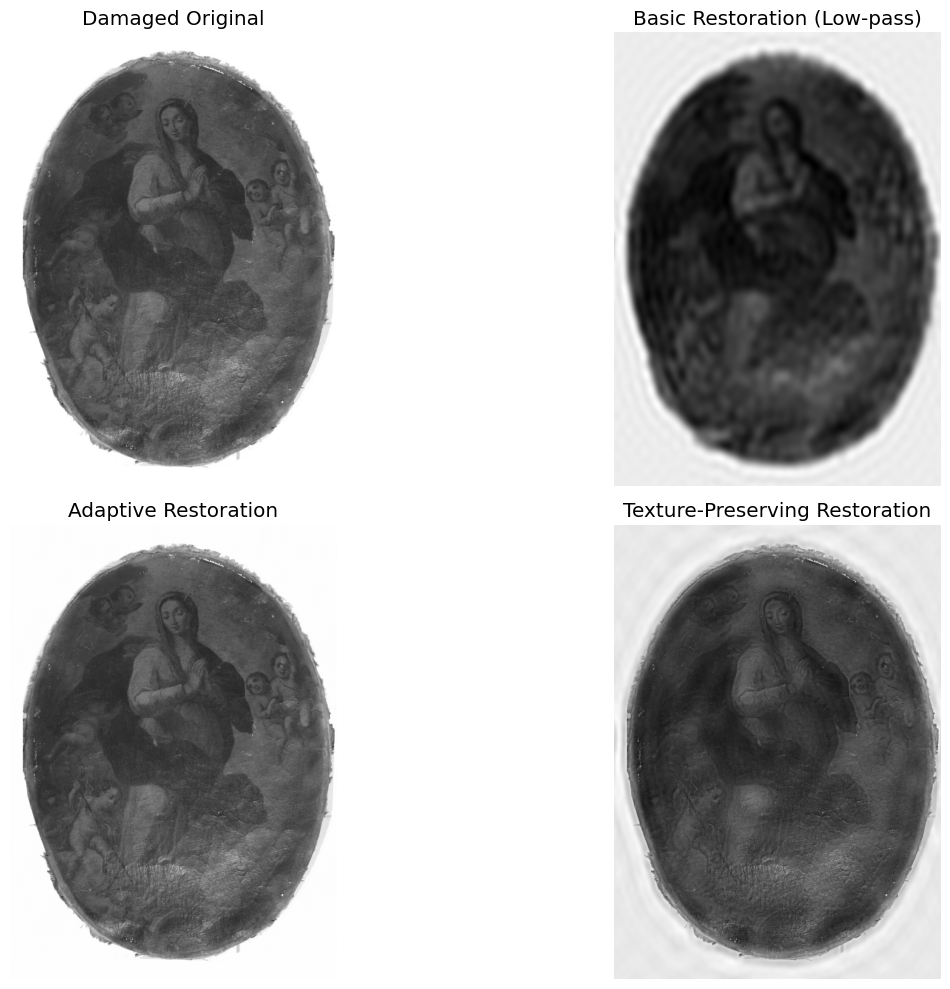

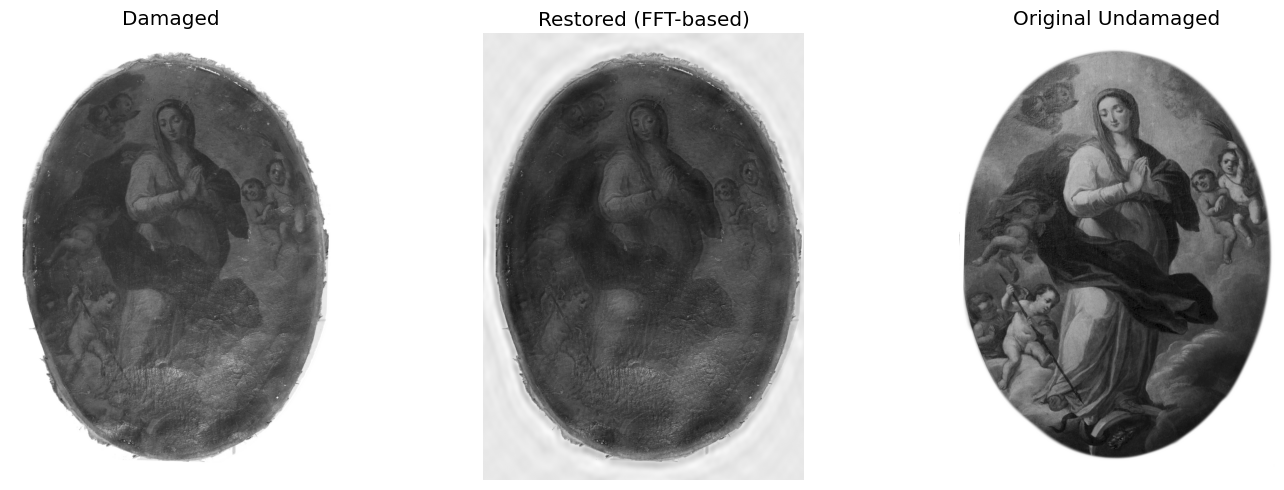

In [15]:
def fft_restoration(image, restoration_type='basic'):
    """Apply FFT-based restoration techniques.
    
    Types of restoration:
    - 'basic': Simple low-pass filtering to remove high-frequency noise
    - 'adaptive': Adaptive filtering based on magnitude spectrum
    - 'texture_preserving': Preserves texture while removing noise
    """
    # Compute FFT
    fshift = compute_fft(image)
    magnitude = compute_magnitude_spectrum(fshift)
    
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    
    if restoration_type == 'basic':
        # Simple low-pass filter
        mask = create_lowpass_filter((rows, cols), cutoff=30)
        restored = apply_filter(fshift, mask)
        
    elif restoration_type == 'adaptive':
        # Create adaptive mask based on magnitude spectrum
        mask = np.ones((rows, cols), dtype=np.float32)
        
        # Calculate average magnitude
        avg_magnitude = np.mean(magnitude)
        
        # Create adaptive mask that preserves strong frequencies
        threshold = 0.8 * avg_magnitude
        mask = np.where(magnitude > threshold, 1, 0.2)
        
        # Apply mask
        restored = apply_filter(fshift, mask)
        
    elif restoration_type == 'texture_preserving':
        # Create a mask that removes only specific frequency bands
        mask = np.ones((rows, cols), dtype=np.float32)
        
        # Remove mid-range frequencies that often contain damage patterns
        mid_mask = create_bandpass_filter((rows, cols), inner_cutoff=15, outer_cutoff=40)
        mask = mask * (1 - mid_mask * 0.8)  # Reduce mid frequencies by 80%
        
        # Apply mask
        restored = apply_filter(fshift, mask)
        
    else:
        raise ValueError(f"Unknown restoration type: {restoration_type}")
    
    # Normalize for better visualization
    restored = cv2.normalize(restored, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    return restored

# Apply restoration techniques to damaged image
if damaged_img is not None:
    # Apply different restoration techniques
    basic_restored = fft_restoration(damaged_img, 'basic')
    adaptive_restored = fft_restoration(damaged_img, 'adaptive')
    texture_preserved = fft_restoration(damaged_img, 'texture_preserving')
    
    # Visualize results
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.imshow(damaged_img, cmap='gray')
    plt.title('Damaged Original')
    plt.axis('off')
    
    plt.subplot(2, 2, 2)
    plt.imshow(basic_restored, cmap='gray')
    plt.title('Basic Restoration (Low-pass)')
    plt.axis('off')
    
    plt.subplot(2, 2, 3)
    plt.imshow(adaptive_restored, cmap='gray')
    plt.title('Adaptive Restoration')
    plt.axis('off')
    
    plt.subplot(2, 2, 4)
    plt.imshow(texture_preserved, cmap='gray')
    plt.title('Texture-Preserving Restoration')
    plt.axis('off')
    
    plt.tight_layout()
    
    # Compare with undamaged if available
    if undamaged_img is not None:
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(damaged_img, cmap='gray')
        plt.title('Damaged')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(texture_preserved, cmap='gray')
        plt.title('Restored (FFT-based)')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(undamaged_img, cmap='gray')
        plt.title('Original Undamaged')
        plt.axis('off')
        
        plt.tight_layout()

## 10. Conclusion and Next Steps

In this notebook, we've explored how FFT analysis can be used for art artifact detection and restoration:

1. **FFT Analysis**: We've seen how the frequency domain can reveal patterns not visible in the spatial domain
2. **Feature Extraction**: We extracted statistical features from the FFT spectrum that can be used for ML models
3. **Frequency Domain Comparison**: We compared damaged and undamaged artworks in the frequency domain
4. **Restoration Techniques**: We implemented FFT-based restoration methods

Next steps could include:

- Implementing a machine learning model using the extracted features to classify real vs. fake/damaged art
- Developing a more sophisticated restoration pipeline that combines FFT with other techniques
- Analyzing larger datasets to identify common patterns in forgeries or damage
- Implementing a deep learning approach like a CNN or U-Net for restoration